Forecasting
- Split real-world time series into train/test sets.
- Fit ARIMA on training, forecast test observations.
- Plot forecasts vs. actuals, what patterns does your model capture or miss?
- Perform residual analysis
- Generate 80% / 95% forecast intervals. Are values within the intervals? What does this imply?

Evaluation workflow
- Use cross-validation to generate different validation folds
- Compute rolling forecast performance. Which metric is best suited for your data?
- Compare ARIMA with baseline models (mean, naïve, seasonal naïve).
- Review sktime forecasting notebook and test different forecasting approaches.
- Select best model and evaluate performance on the test set

Training set: 2023-01-01 00:00:00 to 2025-08-31 00:00:00 (974 days)
Test set: 2025-09-01 00:00:00 to 2025-09-30 00:00:00 (30 days)


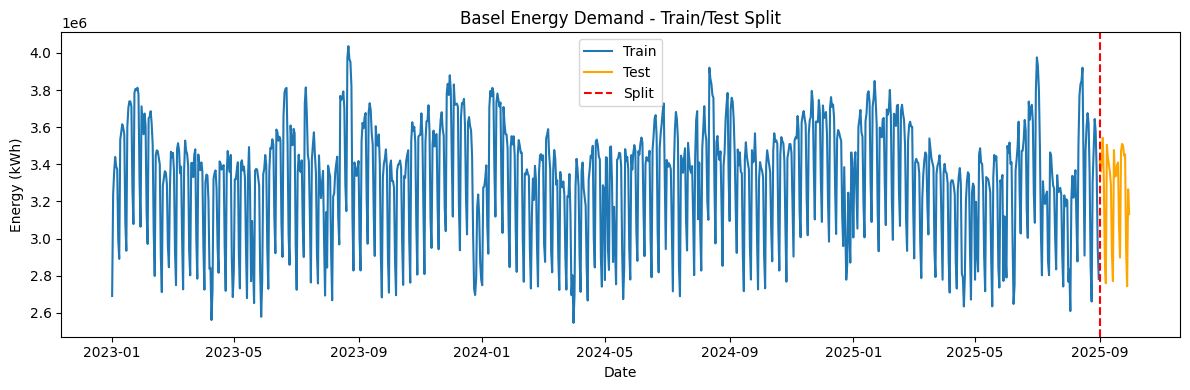

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

# Load the Basel energy demand dataset
df = pd.read_parquet("./basel-energy-demand.parquet")

# Resample to daily frequency for simpler modeling
df["date"] = pd.to_datetime(df["timestamp_interval_start"]).dt.date
daily_df = df.groupby("date")["stromverbrauch_kwh"].sum().reset_index()
daily_df["date"] = pd.to_datetime(daily_df["date"])
daily_df = daily_df.set_index("date")

# Use last 2 years of data for faster computation
series = daily_df["stromverbrauch_kwh"].loc["2023-01-01":]

# Train/test split (last 30 days as test)
# This will limit the patterns we can test for in the final model
train = series[:-30]
test = series[-30:]

print(f"Training set: {train.index[0]} to {train.index[-1]} ({len(train)} days)")
print(f"Test set: {test.index[0]} to {test.index[-1]} ({len(test)} days)")

# Plot the split
plt.figure(figsize=(12, 4))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test", color="orange")
plt.axvline(x=test.index[0], color="red", linestyle="--", label="Split")
plt.title("Basel Energy Demand - Train/Test Split")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
# Fit ARIMA model with weekly seasonality (period=7)
# Using ARIMA(1,1,1) with seasonal order (1,1,1,7)
model = ARIMA(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
fit = model.fit()

print(fit.summary())

# Generate forecasts for test period
forecast_result = fit.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int_80 = forecast_result.conf_int(alpha=0.20)
conf_int_95 = forecast_result.conf_int(alpha=0.05)

print(f"\nForecast generated for {len(forecast)} steps")

                                    SARIMAX Results                                    
Dep. Variable:              stromverbrauch_kwh   No. Observations:                  974
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -12814.959
Date:                         Sat, 29 Nov 2025   AIC                          25639.918
Time:                                 23:19:55   BIC                          25664.283
Sample:                             01-01-2023   HQIC                         25649.194
                                  - 08-31-2025                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3555      0.197      1.806      0.071      -0.030       0.741
ma.L1         -0.5346      0.181     -2.948      0.003     

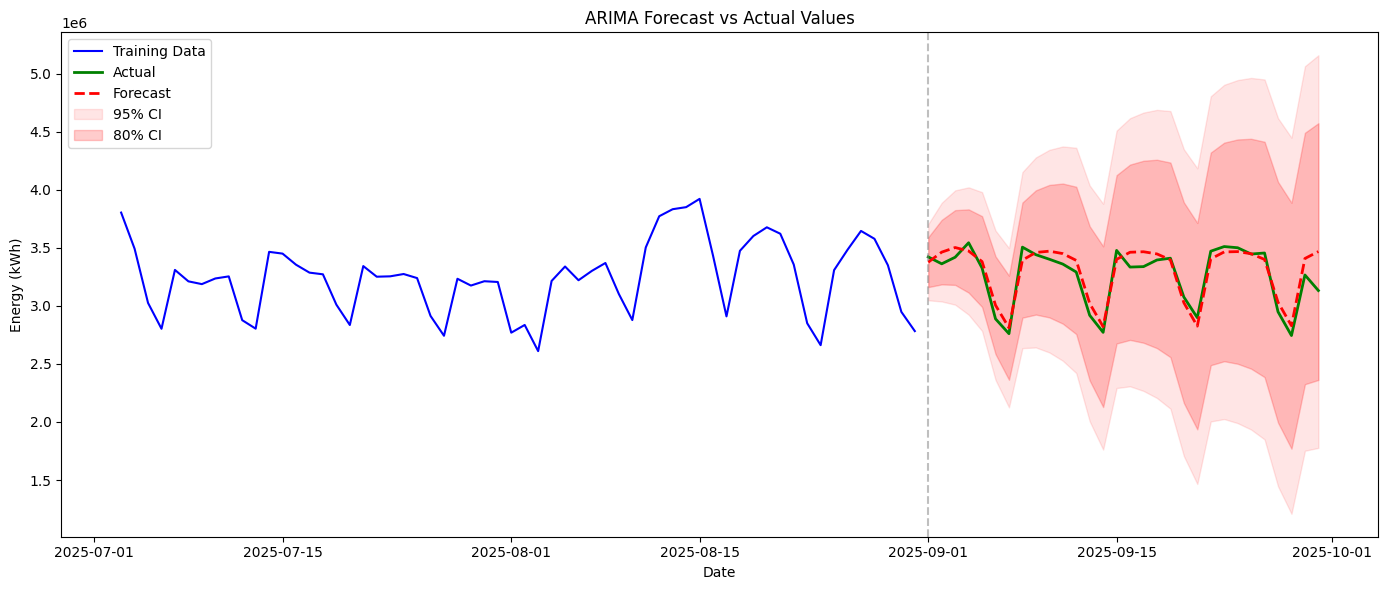

Performance metrics:
MAE: 81,174 kWh
RMSE: 99,822 kWh
MAPE: 2.53%


In [3]:
# Plot forecasts vs actuals
plt.figure(figsize=(14, 6))

# Plot training data (last 60 days for context)
plt.plot(train[-60:].index, train[-60:].values, label='Training Data', color='blue')

# Plot test data
plt.plot(test.index, test.values, label='Actual', color='green', linewidth=2)

# Plot forecast
plt.plot(test.index, forecast.values, label='Forecast', color='red', linestyle='--', linewidth=2)

# Plot confidence intervals
plt.fill_between(test.index, conf_int_95.iloc[:, 0], conf_int_95.iloc[:, 1], 
                 color='red', alpha=0.1, label='95% CI')
plt.fill_between(test.index, conf_int_80.iloc[:, 0], conf_int_80.iloc[:, 1], 
                 color='red', alpha=0.2, label='80% CI')

plt.axvline(x=test.index[0], color='gray', linestyle='--', alpha=0.5)
plt.title('ARIMA Forecast vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

print("Performance metrics:")
print(f"MAE: {mean_absolute_error(test, forecast):,.0f} kWh")
print(f"RMSE: {np.sqrt(mean_squared_error(test, forecast)):,.0f} kWh")
print(f"MAPE: {mean_absolute_percentage_error(test, forecast)*100:.2f}%")

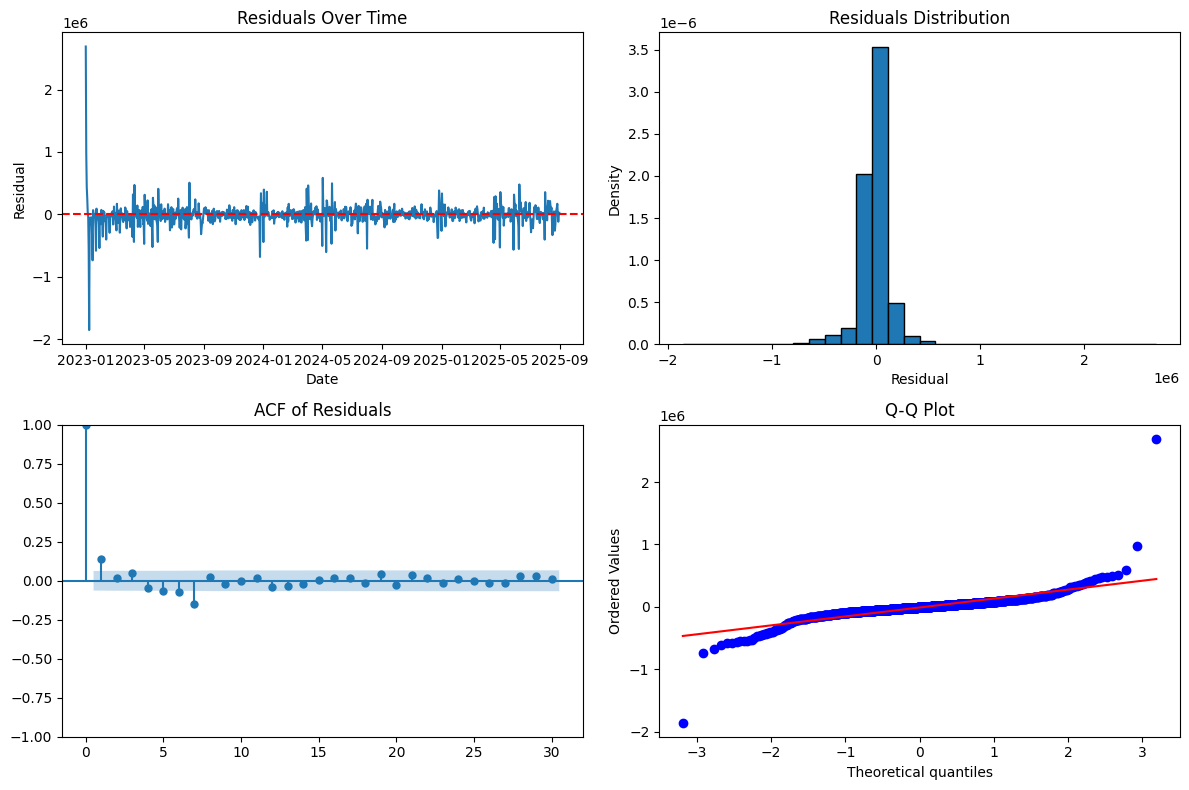

Ljung-Box Test for Residual Autocorrelation:
      lb_stat     lb_pvalue
10  55.663422  2.373476e-08
20  62.164056  3.276607e-06
30  65.984831  1.638795e-04


In [4]:
# Residual Analysis
residuals = fit.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuals over time
axes[0, 0].plot(residuals)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual')

# Histogram
axes[0, 1].hist(residuals, bins=30, edgecolor='black', density=True)
axes[0, 1].set_title('Residuals Distribution')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Density')

# ACF of residuals
plot_acf(residuals, lags=30, ax=axes[1, 0], title='ACF of Residuals')

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box Test for Residual Autocorrelation:")
print(lb_test)

P values are not enough to reject the null null hypothesis, therefore indicating residual autocoreelation which the model does not capture.

In [5]:
# Forecast Intervals Analysis
# Check coverage of 80% and 95% intervals

# 80% interval coverage
in_80_ci = ((test.values >= conf_int_80.iloc[:, 0].values) & 
            (test.values <= conf_int_80.iloc[:, 1].values))
coverage_80 = in_80_ci.mean() * 100

# 95% interval coverage
in_95_ci = ((test.values >= conf_int_95.iloc[:, 0].values) & 
            (test.values <= conf_int_95.iloc[:, 1].values))
coverage_95 = in_95_ci.mean() * 100

print("Forecast Interval Coverage Analysis:")
print(f"80% CI: {coverage_80:.1f}% of actuals within interval (expected: 80%)")
print(f"95% CI: {coverage_95:.1f}% of actuals within interval (expected: 95%)")

Forecast Interval Coverage Analysis:
80% CI: 100.0% of actuals within interval (expected: 80%)
95% CI: 100.0% of actuals within interval (expected: 95%)


80% CI overcoverage: Model may overestimate uncertainty
95% CI overcoverage: Intervals may be too conservative

# Evaluation workflow

In [6]:
# Cross-Validation with Rolling Forecast
# Use expanding window approach

def rolling_forecast_cv(data, initial_train_size, step_size, horizon):
    """Perform rolling forecast cross-validation"""
    results = []
    
    for i in range(0, len(data) - initial_train_size - horizon + 1, step_size):
        train_end = initial_train_size + i
        train_data = data[:train_end]
        test_data = data[train_end:train_end + horizon]
        
        if len(test_data) < horizon:
            break
            
        try:
            model = ARIMA(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
            fit = model.fit()
            forecast = fit.forecast(steps=horizon)
            
            mae = mean_absolute_error(test_data, forecast)
            rmse = np.sqrt(mean_squared_error(test_data, forecast))
            mape = mean_absolute_percentage_error(test_data, forecast) * 100
            
            results.append({
                'fold': len(results) + 1,
                'train_end': train_data.index[-1],
                'mae': mae,
                'rmse': rmse,
                'mape': mape
            })
        except:
            continue
    
    return pd.DataFrame(results)

# Run CV with 5 folds
cv_results = rolling_forecast_cv(train, initial_train_size=len(train)-70, step_size=14, horizon=7)

print("Cross-Validation Results (7-day horizon):")
print(cv_results.to_string(index=False))
print(f"Mean MAE: {cv_results['mae'].mean():,.0f} kWh")
print(f"Mean RMSE: {cv_results['rmse'].mean():,.0f} kWh")
print(f"Mean MAPE: {cv_results['mape'].mean():.2f}%")

Cross-Validation Results (7-day horizon):
 fold  train_end           mae          rmse     mape
    1 2025-06-22  97353.102506 108591.087241 2.723699
    2 2025-07-06 190692.054511 222122.567082 5.987876
    3 2025-07-20 132623.926663 139077.861472 4.198883
    4 2025-08-03 211158.156695 243793.197411 6.674217
    5 2025-08-17 206988.615534 260126.018238 6.832316
Mean MAE: 167,763 kWh
Mean RMSE: 194,742 kWh
Mean MAPE: 5.28%


Previous performance metrics:
- MAE: 81,174 kWh
- RMSE: 99,822 kWh
- MAPE: 2.53%

Most suitable metric for the energy consumption data is MAPE, as it normalizes errors relative to the magnitude of actual values, allowing for better comparison across different scales.

Model Comparison on Test Set:
         Model           MAE          RMSE      MAPE
         ARIMA  81173.997053  99821.954311  2.528851
          Mean 195830.086206 257846.958294  6.416298
         Naive 482469.015100 539746.864876 14.276979
Seasonal Naive 117302.669400 147429.190971  3.536500


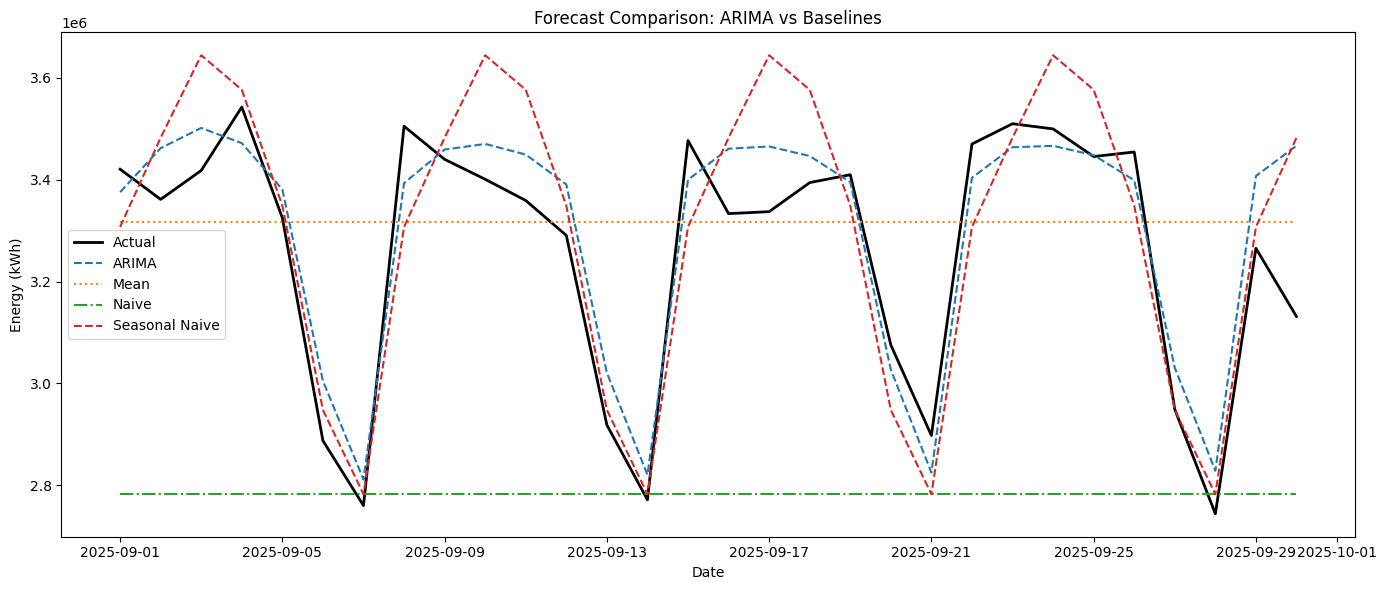

In [7]:
# Compare ARIMA with Baseline Models

# 1. Mean forecast (historical mean)
mean_forecast = np.full(len(test), train.mean())

# 2. Naive forecast (last observation)
naive_forecast = np.full(len(test), train.iloc[-1])

# 3. Seasonal naive forecast (same day last week)
seasonal_naive_forecast = train.iloc[-7:].values
seasonal_naive_forecast = np.tile(seasonal_naive_forecast, (len(test) // 7) + 1)[:len(test)]

# Calculate metrics for all models
models = {
    'ARIMA': forecast.values,
    'Mean': mean_forecast,
    'Naive': naive_forecast,
    'Seasonal Naive': seasonal_naive_forecast
}

comparison = []
for name, pred in models.items():
    comparison.append({
        'Model': name,
        'MAE': mean_absolute_error(test, pred),
        'RMSE': np.sqrt(mean_squared_error(test, pred)),
        'MAPE': mean_absolute_percentage_error(test, pred) * 100
    })

comparison_df = pd.DataFrame(comparison)
print("Model Comparison on Test Set:")
print(comparison_df.to_string(index=False))

# Plot all forecasts
plt.figure(figsize=(14, 6))
plt.plot(test.index, test.values, label='Actual', color='black', linewidth=2)
plt.plot(test.index, forecast.values, label='ARIMA', linestyle='--')
plt.plot(test.index, mean_forecast, label='Mean', linestyle=':')
plt.plot(test.index, naive_forecast, label='Naive', linestyle='-.')
plt.plot(test.index, seasonal_naive_forecast, label='Seasonal Naive', linestyle='--')
plt.title('Forecast Comparison: ARIMA vs Baselines')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

Fitting Exponential Smoothing...
Fitting AutoETS...
Fitting AutoETS...
Fitting Theta...
Fitting Seasonal Naive (sktime)...
All sktime models fitted!

All Models Comparison (sorted by MAPE):
              Model           MAE          RMSE      MAPE
              Theta  73543.643172  92537.936483  2.249379
            AutoETS  73579.932625  92317.836008  2.255233
       ExpSmoothing  74163.061116  93045.363384  2.276503
ARIMA (statsmodels)  81173.997053  99821.954311  2.528851
   SeasonalNaive_sk 117302.669400 147429.190971  3.536500
               Mean 195830.086206 257846.958294  6.416298
              Naive 482469.015100 539746.864876 14.276979
Fitting Theta...
Fitting Seasonal Naive (sktime)...
All sktime models fitted!

All Models Comparison (sorted by MAPE):
              Model           MAE          RMSE      MAPE
              Theta  73543.643172  92537.936483  2.249379
            AutoETS  73579.932625  92317.836008  2.255233
       ExpSmoothing  74163.061116  93045.363384  2.27

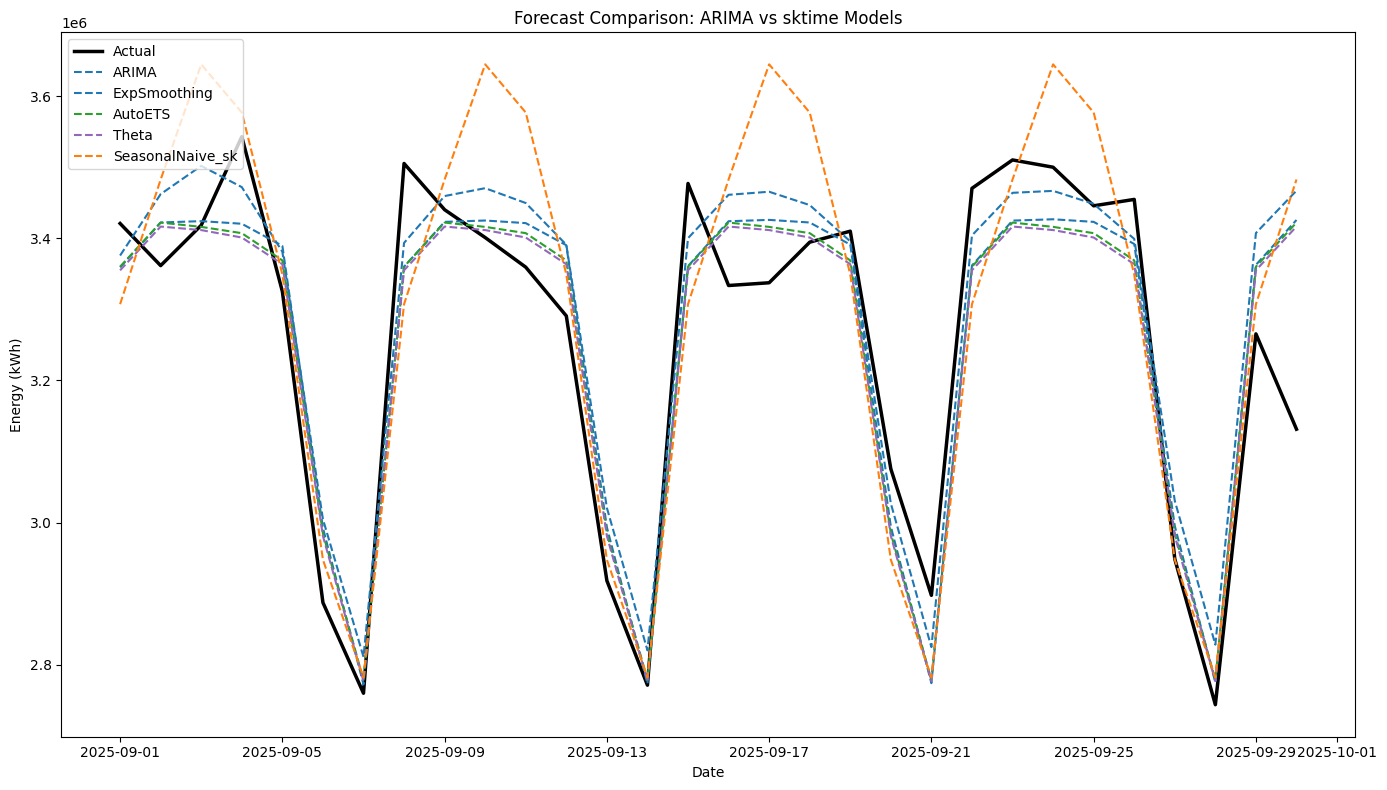

In [8]:
# sktime Forecasting Models Comparison
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.theta import ThetaForecaster

# Prepare data for sktime - must have frequency set on index
train_sk = train.copy()
train_sk.index = pd.DatetimeIndex(train_sk.index, freq='D')
fh = np.arange(1, len(test) + 1)  # forecast horizon

# Dictionary to store sktime forecasts
sktime_models = {}

# 1. Exponential Smoothing (Holt-Winters with additive seasonality)
print("Fitting Exponential Smoothing...")
es = ExponentialSmoothing(sp=7, trend="add", seasonal="add")
es.fit(train_sk)
sktime_models['ExpSmoothing'] = es.predict(fh)

# 2. AutoETS (automatic selection of ETS model)
print("Fitting AutoETS...")
autoets = AutoETS(sp=7, auto=True)
autoets.fit(train_sk)
sktime_models['AutoETS'] = autoets.predict(fh)

# 3. Theta Forecaster
print("Fitting Theta...")
theta = ThetaForecaster(sp=7)
theta.fit(train_sk)
sktime_models['Theta'] = theta.predict(fh)

# 4. Seasonal Naive (sktime version)
print("Fitting Seasonal Naive (sktime)...")
snaive = NaiveForecaster(strategy="last", sp=7)
snaive.fit(train_sk)
sktime_models['SeasonalNaive_sk'] = snaive.predict(fh)

print("All sktime models fitted!")

# Calculate metrics for all models
all_comparison = []

# Add statsmodels ARIMA result
all_comparison.append({
    'Model': 'ARIMA (statsmodels)',
    'MAE': mean_absolute_error(test, forecast),
    'RMSE': np.sqrt(mean_squared_error(test, forecast)),
    'MAPE': mean_absolute_percentage_error(test, forecast) * 100
})

# Add sktime models
for name, pred in sktime_models.items():
    pred_values = pred.values if hasattr(pred, 'values') else pred
    all_comparison.append({
        'Model': name,
        'MAE': mean_absolute_error(test, pred_values),
        'RMSE': np.sqrt(mean_squared_error(test, pred_values)),
        'MAPE': mean_absolute_percentage_error(test, pred_values) * 100
    })

# Add baselines
all_comparison.append({'Model': 'Mean', 'MAE': mean_absolute_error(test, mean_forecast),
                       'RMSE': np.sqrt(mean_squared_error(test, mean_forecast)),
                       'MAPE': mean_absolute_percentage_error(test, mean_forecast) * 100})
all_comparison.append({'Model': 'Naive', 'MAE': mean_absolute_error(test, naive_forecast),
                       'RMSE': np.sqrt(mean_squared_error(test, naive_forecast)),
                       'MAPE': mean_absolute_percentage_error(test, naive_forecast) * 100})

all_comparison_df = pd.DataFrame(all_comparison).sort_values('MAPE')
print("\nAll Models Comparison (sorted by MAPE):")
print(all_comparison_df.to_string(index=False))

# Plot comparison
plt.figure(figsize=(14, 8))
plt.plot(test.index, test.values, label='Actual', color='black', linewidth=2.5)
plt.plot(test.index, forecast.values, label='ARIMA', linestyle='--', linewidth=1.5)

colors = ['tab:blue', 'tab:green', 'tab:purple', 'tab:orange']
for (name, pred), color in zip(sktime_models.items(), colors):
    pred_values = pred.values if hasattr(pred, 'values') else pred
    plt.plot(test.index, pred_values, label=name, linestyle='--', color=color)

plt.title('Forecast Comparison: ARIMA vs sktime Models')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Final Model Comparison Summary

**Best Model:** Theta Forecaster (MAPE: 2.25%)

**Models Tested (ranked by MAPE):**
1. Theta Forecaster - 2.25% MAPE
2. AutoETS - 2.26% MAPE
3. Exponential Smoothing (Holt-Winters) - 2.28% MAPE
4. ARIMA(1,1,1)(1,1,1,7) - 2.53% MAPE
5. Seasonal Naive - 3.54% MAPE
6. Mean - 6.42% MAPE
7. Naive - 14.28% MAPE

**Key Findings:**
1. The Theta method outperforms all other models with the lowest MAPE
2. AutoETS and Exponential Smoothing perform nearly identically to Theta
3. ARIMA performs reasonably well but is outperformed by simpler ETS-based methods
    - ARIMA may be overfit or the order selection could be improved
4. Seasonal Naive is a decent baseline but significantly worse than statistical models
5. Mean and Naive forecasts perform poorly - this data has strong patterns they cannot capture


**Patterns Captured:**
- Weekly seasonality (weekday vs weekend differences)
- Short-term trends in energy consumption

**Patterns Missed:**
- Holiday effects
- Weather-related demand spikes
- Long-term structural changes